1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score

import joblib


# %load_ext autoreload
#%autoreload 2

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [5]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

2. Data Analysis

In [6]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [7]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [8]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [9]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [10]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [11]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [12]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [13]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [14]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [15]:
# df.gender.value_counts()
df.age.min()


0.08

In [16]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [17]:
df[df.age<30].stroke.value_counts()

0    1513
1       2
Name: stroke, dtype: int64

In [18]:
df[df.age<39].stroke.value_counts()

0    2094
1       5
Name: stroke, dtype: int64

In [19]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [20]:
df.avg_glucose_level.min()


55.12

In [21]:
df.avg_glucose_level.max()

271.74

In [22]:
df.bmi.isna().value_counts()

False    4909
True      201
Name: bmi, dtype: int64

In [23]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [24]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [25]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [26]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [27]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [28]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [29]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


1    2596
0    2514
Name: Residence_type, dtype: int64

In [30]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [32]:
# from sklearn.preprocessing import OneHotEncoder

# categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

# OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

In [33]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [34]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [35]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [36]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]


    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df.bmi.fillna(0, inplace=True)


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe036ac1c10>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe036ac1b20>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe036ad3250>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe036ad35b0>}

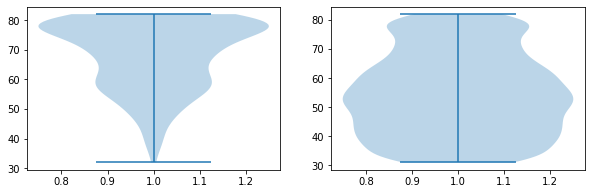

In [37]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe0369470a0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe036926f70>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe036947640>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe0369479a0>}

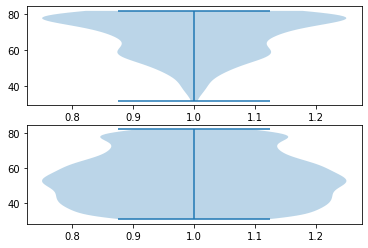

In [38]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe036824310>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe0369c5040>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe0368248b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe036824c10>}

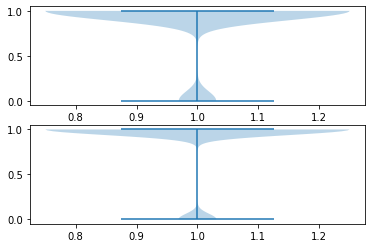

In [39]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

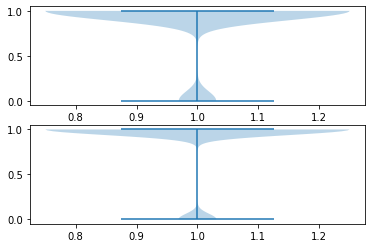

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


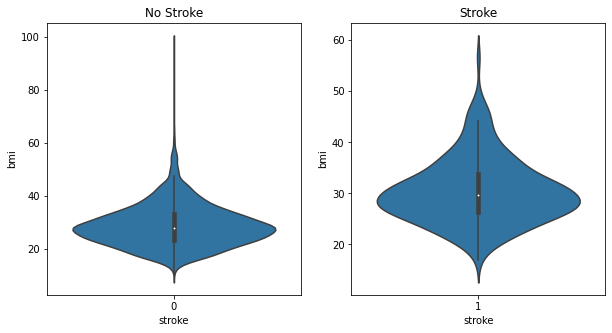

In [41]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=df[df.stroke != 1].dropna(), ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=df[df.stroke == 1].dropna(), ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


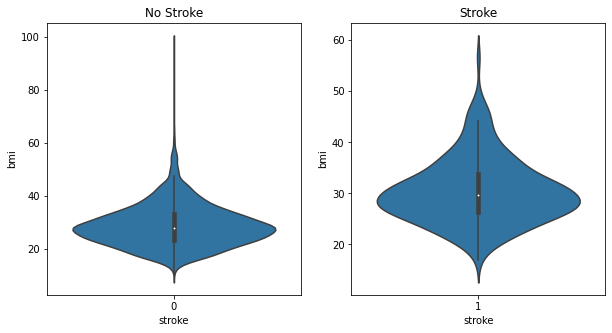

In [42]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=df[df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=df[df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


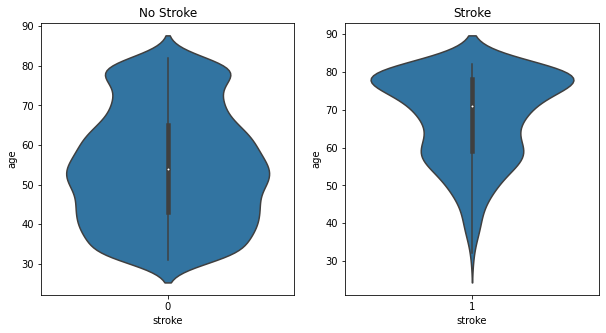

In [43]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


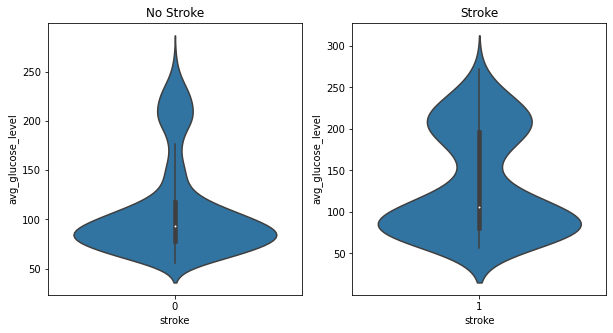

In [44]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [45]:
clean_df.stroke.value_counts(normalize=True)

0    0.930048
1    0.069952
Name: stroke, dtype: float64

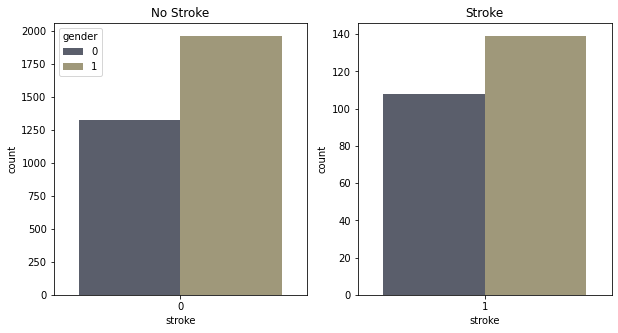

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


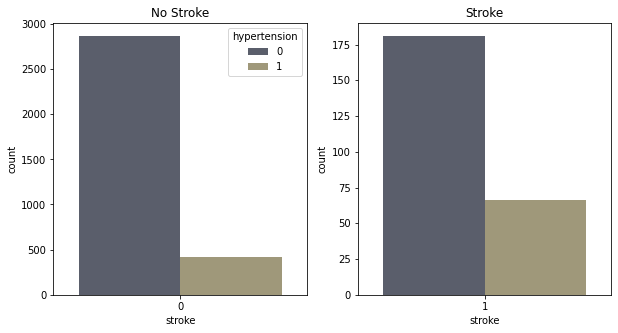

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


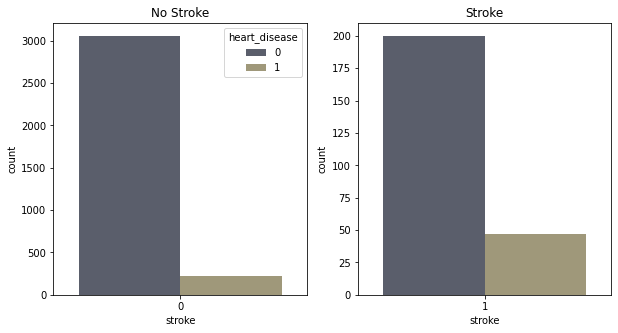

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


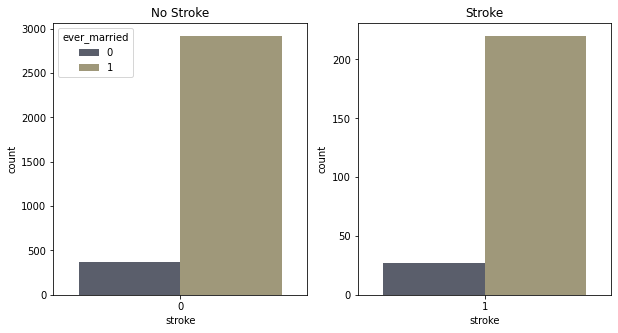

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [50]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

1    0.888855
0    0.111145
Name: ever_married, dtype: float64

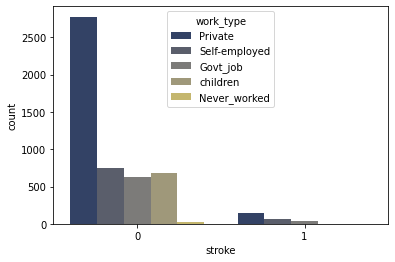

In [51]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

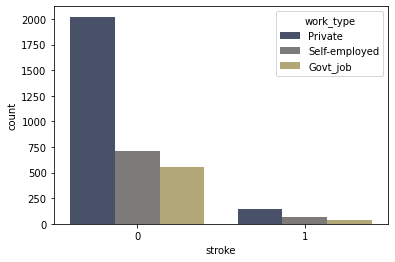

In [52]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


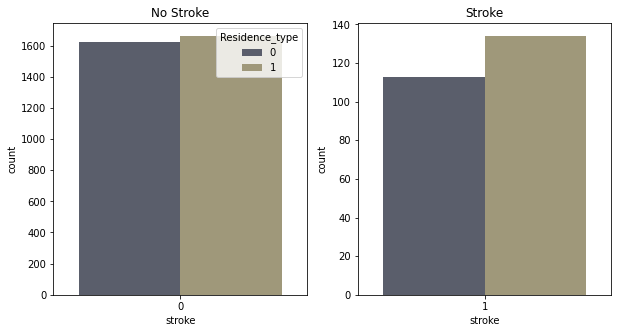

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


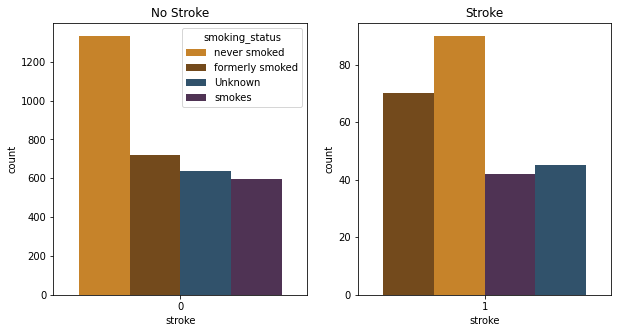

In [54]:
custom_palette = {'Unknown': '#275375', 'formerly smoked': '#824b0d', 'never smoked': '#e08610', 'smokes': '#532e59'}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==0], palette=custom_palette, ax=axs[0])
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==1], palette=custom_palette, ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [55]:
clean_df[clean_df.stroke ==1].smoking_status.value_counts()

never smoked       90
formerly smoked    70
Unknown            45
smokes             42
Name: smoking_status, dtype: int64

In [56]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [57]:
from sklearn.svm import SVC

In [58]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,28.1,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


In [59]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [60]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 200, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/l

/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/l

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.98000
# Mean r2 Test_Score: 0.08664
# Average prediction error: ~0.9504 (RMSE)
min/max recall result[0.0, 1.0]


/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [61]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [62]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

In [63]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [64]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([1])

4. Machine Learning


In [65]:
df_x = df.drop(columns ="stroke")
df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [66]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]

#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

#     # from Sacia
#     clean_df = clean_df[clean_df.bmi <= 60]

#     # A CHANGER ABSOLUMENT
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

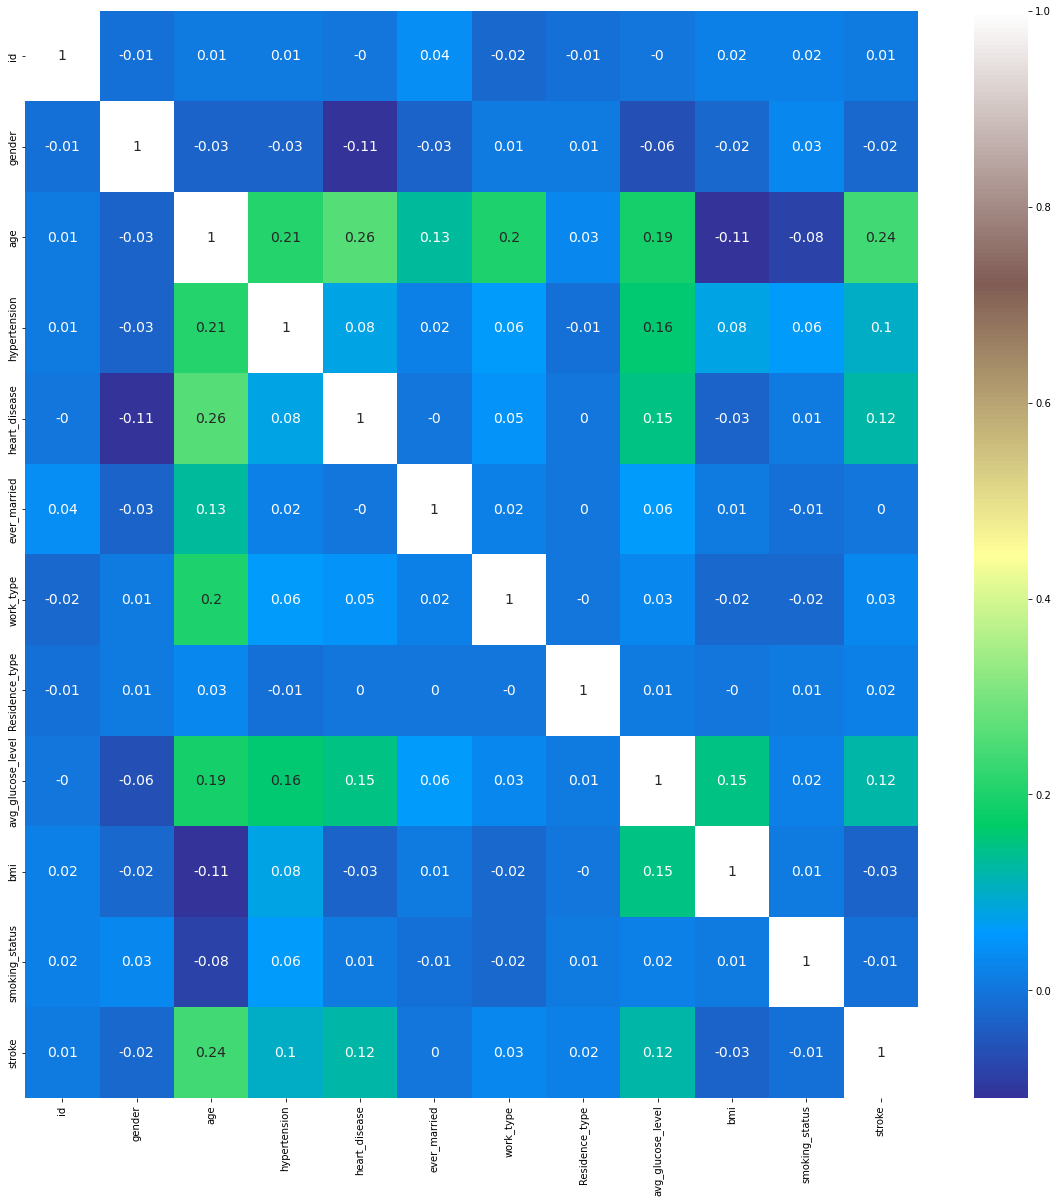

In [67]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [68]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.72150
# Mean r2 Test_Score: 0.69847
# Average prediction error: ~0.5490 (RMSE)
min/max recall result[0.5932203389830508, 0.8709677419354839]


with undersampling

In [69]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [70]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.70367
# Mean r2 Test_Score: 0.68054
# Average prediction error: ~0.5647 (RMSE)
min/max recall result[0.6857142857142857, 0.7368421052631579]


With both undersampling and oversampling

In [71]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [72]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.70396
# Mean r2 Test_Score: 0.69104
# Average prediction error: ~0.5554 (RMSE)
min/max recall result[0.6089743589743589, 0.782608695652174]


One by One Features

In [73]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


In [74]:
# clean_df

Categorical

In [75]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.66560
# Mean r2 Test_Score: 0.52990
# Average prediction error: ~0.6854 (RMSE)
min/max recall result[0.18543046357615894, 0.8287671232876712]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [76]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.60826
# Mean r2 Test_Score: 0.52761
# Average prediction error: ~0.6870 (RMSE)
min/max recall result[0.3237410071942446, 0.6853146853146853]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [77]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.52382
# Mean r2 Test_Score: 0.50283
# Average prediction error: ~0.7049 (RMSE)
min/max recall result[0.3918918918918919, 0.6064516129032258]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [78]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [79]:
# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]


#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



#     # from Sacia
#     clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
#     clean_df = clean_df[clean_df.bmi <= 60]

#     # A CHANGER ABSOLUMENT
#     clean_df.bmi.fillna(0, inplace=True)


# clean_df.shape

In [80]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.72811
# Mean r2 Test_Score: 0.69818
# Average prediction error: ~0.5490 (RMSE)
min/max recall result[0.6451612903225806, 0.8108108108108109]


In [81]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.69122
# Mean r2 Test_Score: 0.67886
# Average prediction error: ~0.5663 (RMSE)
min/max recall result[0.6099290780141844, 0.7533333333333333]


# RandomForestClassifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)



# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))


In [83]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.83237
# Mean r2 Test_Score: 0.71178
# Average prediction error: ~0.5363 (RMSE)
min/max recall result[0.7733333333333333, 0.8918918918918919]


In [84]:
from sklearn.tree import DecisionTreeClassifier
import joblib


In [85]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [86]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.78984
# Mean r2 Test_Score: 0.60843
# Average prediction error: ~0.6227 (RMSE)
min/max recall result[0.4142857142857143, 0.9506172839506173]


In [87]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
#     clean_df = clean_df[clean_df.bmi <= 60]


In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', KNeighborsClassifier(n_neighbors = 20, algorithm='kd_tree')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")

print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.00000
# Mean r2 Test_Score: 0.93321
# Average prediction error: ~0.2582 (RMSE)
min/max recall result[0.0, 0.0]


1. Imports

In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# %load_ext autoreload
#%autoreload 2

# import re

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, LogisticRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score

import joblib

In [93]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [94]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [95]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [96]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

2. Data Analysis

In [97]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [98]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [99]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [100]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [101]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [102]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [103]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [104]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [105]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [106]:
# df.gender.value_counts()
df.age.min()


0.08

In [107]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [108]:
df[df.age<30].stroke.value_counts()

0    1513
1       2
Name: stroke, dtype: int64

In [109]:
df[df.age<39].stroke.value_counts()

0    2094
1       5
Name: stroke, dtype: int64

In [110]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [111]:
df.avg_glucose_level.min()


55.12

In [112]:
df.avg_glucose_level.max()

271.74

In [113]:
df.bmi.isna().value_counts()

False    4909
True      201
Name: bmi, dtype: int64

In [114]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [115]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [116]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [117]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [118]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [119]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [120]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


1    2596
0    2514
Name: Residence_type, dtype: int64

In [121]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [122]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [123]:
# from sklearn.preprocessing import OneHotEncoder

# categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

# OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

In [124]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [125]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [126]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [127]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]
#     # clean_df = clean_df.dropna(axis=0, subset='bmi')

#     # binaires à faire dans la pipeline dans le script bonus
#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
#     # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
#     clean_df.bmi.fillna(0, inplace=True)
#     clean_df = clean_df[clean_df.bmi <= 60]

df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]


    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df.bmi.fillna(0, inplace=True)



{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe0368f9820>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe0340edeb0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe0341b30a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe0341b3880>}

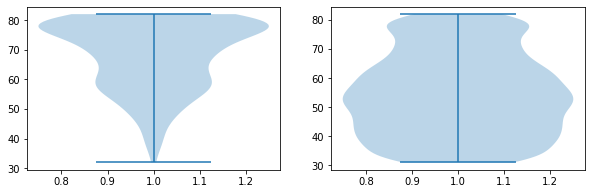

In [128]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe034544bb0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe034544a60>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe033f44190>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe033f444f0>}

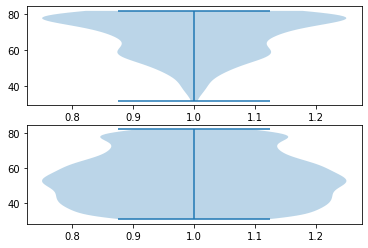

In [129]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

In [130]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,1,83.75,28.1,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,0,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [131]:
clean_df.gender.value_counts()

1    2099
0    1432
Name: gender, dtype: int64

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe0748fc2e0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe0748fc1f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe0748fc880>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe0748fcbe0>}

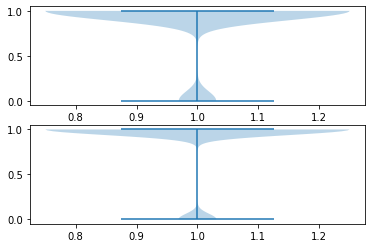

In [132]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

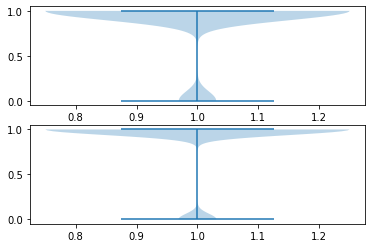

In [133]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


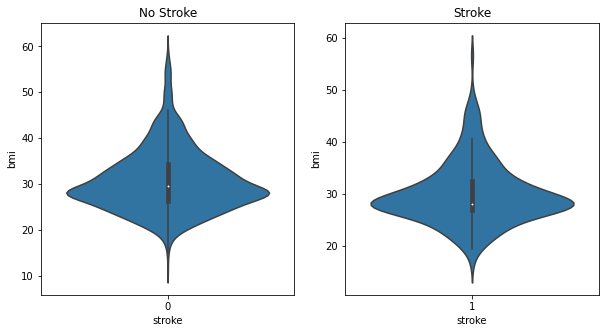

In [134]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


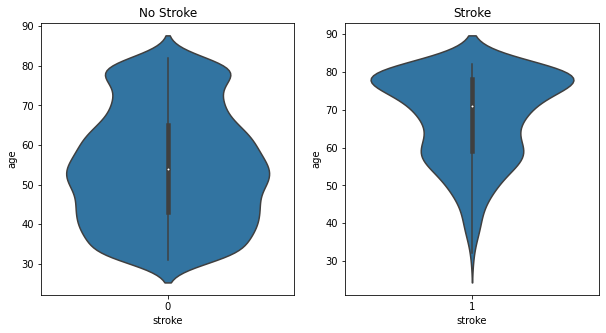

In [135]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


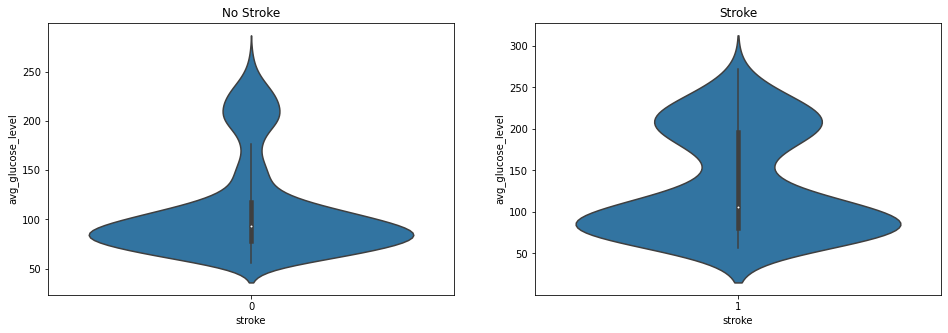

In [136]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [137]:
clean_df.stroke.value_counts(normalize=True)

0    0.930048
1    0.069952
Name: stroke, dtype: float64

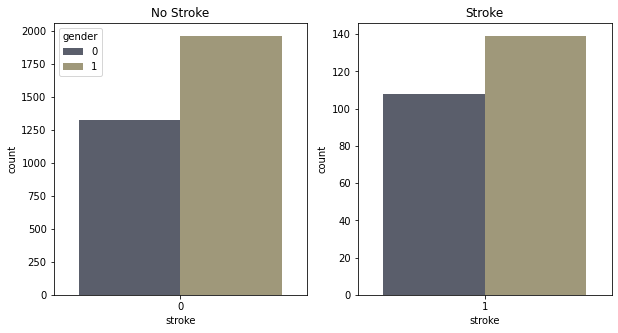

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


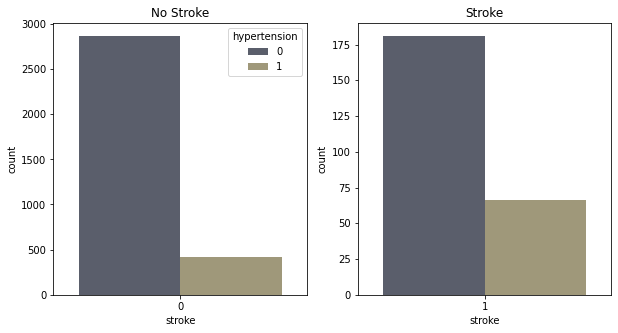

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


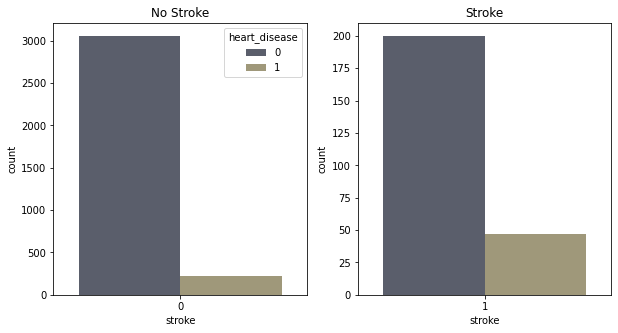

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


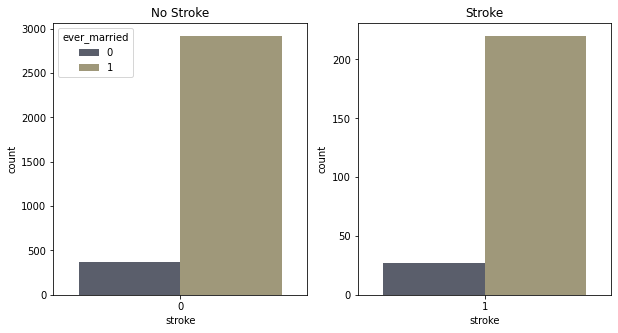

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [142]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

1    0.888855
0    0.111145
Name: ever_married, dtype: float64

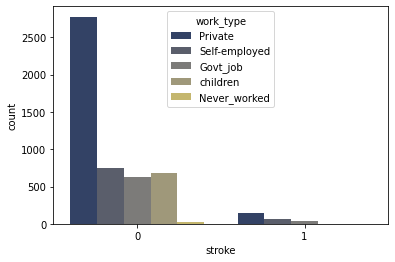

In [143]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

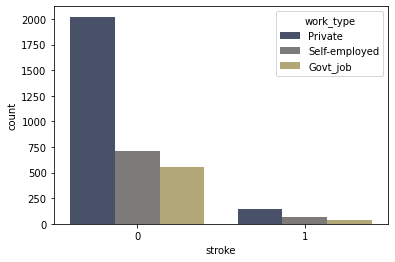

In [144]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


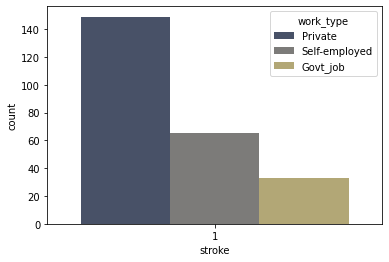

In [145]:
sns.countplot(x='stroke', hue='work_type', data=clean_df[clean_df.stroke ==1], palette="cividis")
plt.show()

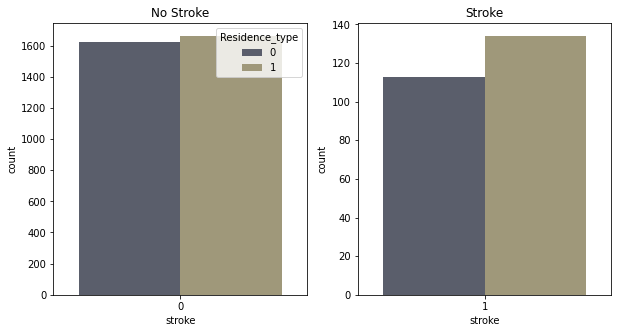

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [147]:

plt.show()

In [148]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [149]:
from sklearn.svm import SVC

In [150]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,28.1,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


In [151]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [152]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 200, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/l

/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/l

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 1.00000
# Mean r2 Test_Score: 0.06955
# Average prediction error: ~0.9646 (RMSE)
min/max recall result[1.0, 1.0]


/home/julienrm/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [153]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [154]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

In [155]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [156]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([1])

4. Machine Learning


In [157]:
# df_x = df.drop(columns ="stroke")
# df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [158]:
# df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# clean_df = df.copy()

# if "Other" in clean_df.gender.value_counts():
#     clean_df = df[df.gender != 'Other']
#     # on va en discuter tkt
#     clean_df = clean_df[clean_df.age>30]

#     clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
#     clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
#     clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

#     # from Sacia
#     clean_df = clean_df[clean_df.bmi <= 60]

#     # A CHANGER ABSOLUMENT
#     clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

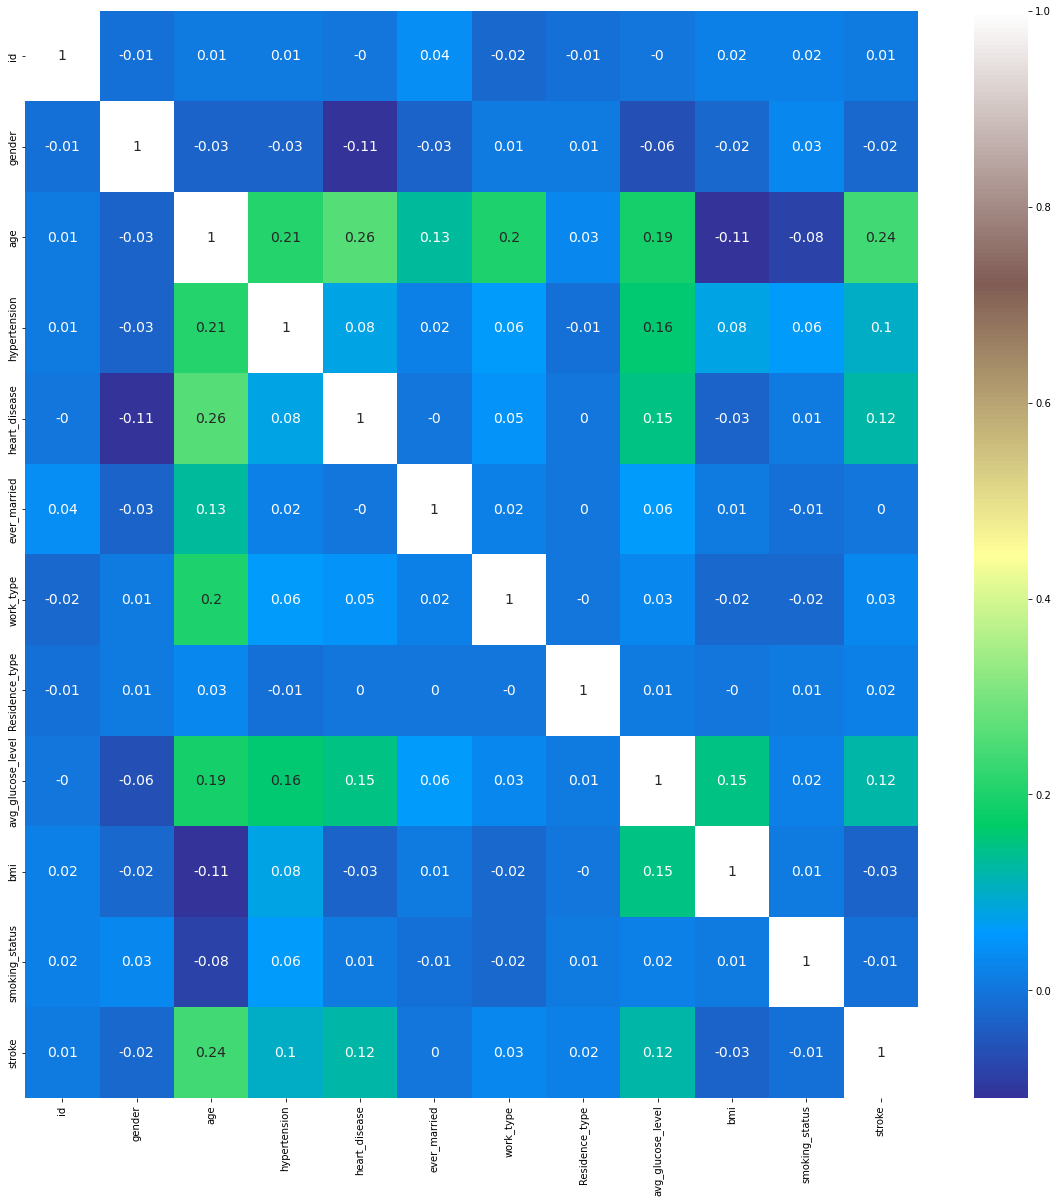

In [159]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [160]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.71217
# Mean r2 Test_Score: 0.70051
# Average prediction error: ~0.5472 (RMSE)
min/max recall result[0.5921052631578947, 0.8375]


with undersampling

In [161]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [162]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.70466
# Mean r2 Test_Score: 0.68483
# Average prediction error: ~0.5607 (RMSE)
min/max recall result[0.5394736842105263, 0.8507462686567164]


With both undersampling and oversampling

In [163]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [164]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.72128
# Mean r2 Test_Score: 0.69589
# Average prediction error: ~0.5511 (RMSE)
min/max recall result[0.6466666666666666, 0.7948717948717948]


One by One Features

In [165]:
# clean_df

Categorical

In [166]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.62508
# Mean r2 Test_Score: 0.52828
# Average prediction error: ~0.6866 (RMSE)
min/max recall result[0.18115942028985507, 0.8523489932885906]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [167]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.59980
# Mean r2 Test_Score: 0.52492
# Average prediction error: ~0.6889 (RMSE)
min/max recall result[0.33774834437086093, 0.6875]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [168]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.52934
# Mean r2 Test_Score: 0.50054
# Average prediction error: ~0.7064 (RMSE)
min/max recall result[0.37748344370860926, 0.6058394160583942]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [169]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [170]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.72560
# Mean r2 Test_Score: 0.69259
# Average prediction error: ~0.5541 (RMSE)
min/max recall result[0.6666666666666666, 0.785234899328859]


In [171]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.68764
# Mean r2 Test_Score: 0.67926
# Average prediction error: ~0.5659 (RMSE)
min/max recall result[0.5911949685534591, 0.75]


# RandomForestClassifier

In [172]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)



# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))


In [173]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.82538
# Mean r2 Test_Score: 0.70121
# Average prediction error: ~0.5462 (RMSE)
min/max recall result[0.7573529411764706, 0.8758169934640523]


In [174]:
from sklearn.tree import DecisionTreeClassifier
import joblib


In [175]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [176]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender'] # , 'gender'

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', LogisticRegression(random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/current_model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.71165
# Mean r2 Test_Score: 0.69830
# Average prediction error: ~0.5492 (RMSE)
min/max recall result[0.6493506493506493, 0.8225806451612904]


In [177]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender'] # , 'gender'

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.79525
# Mean r2 Test_Score: 0.60991
# Average prediction error: ~0.6227 (RMSE)
min/max recall result[0.5416666666666666, 0.8823529411764706]


In [178]:
X.iloc[0, :]

smoking_status    formerly smoked
age                          67.0
bmi                          36.6
Residence_type                  1
gender                          0
Name: 0, dtype: object

In [179]:
model = joblib.load('app/app_model/model.pkl')
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['smoking_status']),
                                                 ('robust_scaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi'])])),
                ('random_forest',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                                        random_state=0))])>

# Script

In [180]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [181]:
clean_df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 3531, dtype: object

In [182]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [183]:


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.79065
# Mean r2 Test_Score: 0.60857
# Average prediction error: ~0.6225 (RMSE)
min/max recall result[0.42028985507246375, 0.9397590361445783]


In [184]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,0.0,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,1,83.75,0.0,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,0,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


# Learning curve


In [185]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [186]:
# # %%writefile my_python_file.py
# # All Columns to preprocess
# # to_classify = ['work_type', 'smoking_status' ]
# # to_robust = ['age', 'avg_glucose_level', 'bmi']
# # # to_min_max = []
# # already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# # Bench : 'MiscFeature'
# # select_features = ['work_type'] # + to_min_max
# select_features = ['Residence_type']

# X = clean_df[select_features]
# y = clean_df['stroke']  # Target
# r2list = []
# rmse_list = []
# recall_list = []

# # allow more accurate model's performance estimation with more training reps and
# # different data splits on a small amount of data, needs to be 1 for prediction tasks.
# for i in range(50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
#         random_state=np.random.randint(1, 20001))

#     # Building Pipeline
#     preprocessor = ColumnTransformer([
#         ('onehot', OneHotEncoder(), select_features),
#         # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
#         # ('minmax', MinMaxScaler(), to_min_max),
#     ], remainder='passthrough')  # passthrough/drop

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', learning_curve(estimator=SVR, X=X_test, y=y_test, cv=5))  # Linear Regression model class_weight='balanced' , n_jobs=4
#     ])
#     # print(f"{X_train, y_train}")
#     pipeline.fit(X_train, y_train)
#     r2list.append(pipeline.score(X_test, y_test))

#     predicted_strokes = pipeline.predict(X_test)
#     rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
#     recall_list.append(recall_score(y_test, predicted_strokes))

# print(f"# Used features count : {len(select_features)}") #/len(df.columns)
# print(f"# Mean Recall: {np.mean(recall_list):.5f}")
# print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# # Display RMSE
# print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


# print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Script

In [187]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [188]:
clean_df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 3531, dtype: object

In [189]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [191]:


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('decision_tree_classifier', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.85584
# Mean r2 Test_Score: 0.58406
# Average prediction error: ~0.6447 (RMSE)
min/max recall result[0.8, 0.9333333333333333]
